In [1]:
import jax.numpy as jnp
import jax
import scipy
import numpy as np
from bilby.core.prior import TruncatedGaussian
import h5py
import matplotlib.pyplot as plt

In [227]:
class GGpulsar(object):
    def __init__(self, mu_p, sigma_p, xp = "jax"):
        if xp == "jax":
            self.xp=jnp
            self.norm = jax.scipy.stats.norm
        elif (xp == "np") or (xp == "numpy"):
            self.xp = np
            self.norm = scipy.stats.norm

        self.mu_p = self.xp.array(mu_p)[...,None]
        self.sigma_p = self.xp.array(sigma_p)[...,None]
        
    def likelihood_m(self, m):
        prob = self.norm.pdf(x=m,loc=self.mu_p, scale=self.sigma_p)
        return prob

In [228]:
class QGpulsar(object):
    def __init__(self, mu_q, sigma_q, f, n_samples = 2000, xp = "jax"):
        self.n_obs = len(mu_q)
        self.mu_q = mu_q
        self.sigma_q = sigma_q
        if xp == "jax":
            self.xp=jnp
        elif (xp == "np") or (xp == "numpy"):
            self.xp = np
            
        self.f = self.xp.array(f)
        self.n_samples = n_samples
        self.draw_q_samples()
        
    def draw_q_samples(self):
        q_samples = []
        for i in range(len(self.mu_q)):
            pq = TruncatedGaussian(mu = self.mu_q[i], sigma = self.sigma_q[i], minimum = 0, maximum = np.inf)
            q_samples.append(pq.sample(self.n_samples))
        self.q_samples = self.xp.array(q_samples)
        
    def likelihood_m(self, m):
        q = self.q_samples
        f = self.f
        # Reshape m and f to broadcast properly with q
        m = m[:, None, None]  # Shape (len(m), 1, 1)
        f = f[None, :, None]  # Shape (1, n_obs, 1)
        q = q[None, :, :]  # Shape (1, n_obs, n_samples)

        term1 = (1 + q) ** (4 / 3)
        term2 = (f / m) ** (2 / 3) * term1 / q ** 2
        weights = term1 / (3 * f ** (1 / 3) * m ** (2 / 3) * q ** 2 * self.xp.sqrt(1 - term2))
        weights *= m

        return self.xp.mean(weights, axis=2).T  # Return mean over samples axis, shape (n_obs, len(m))

In [277]:
class MTpulsar(object):
    def __init__(self, mu_mt, sigma_mt, f, n_samples = 3000, min_mc = 0.2, xp = np):
        self.n_obs = len(mu_mt)
        self.mu_mt = mu_mt
        self.sigma_mt = sigma_mt
        if xp == "jax":
            self.xp=jnp
            self.norm = jax.scipy.stats.norm
        elif (xp == "np") or (xp == "numpy"):
            self.xp = np
            self.norm = scipy.stats.norm
        
        self.f = self.xp.array(f[...,None])
        self.n_samples = n_samples
        self.min_mc = min_mc
        self.draw_mt_samples()
    """
        
    def draw_mt_samples(self):
        mt_samples = []
        for i in range(len(self.mu_mt)):
            pmt = TruncatedGaussian(mu = float(self.mu_mt[i]), sigma = float(self.sigma_mt[i]), minimum = 0, maximum = 10)
            samples = pmt.sample(self.n_samples)
            mt_samples.append(samples)
            
        self.mt_samples = self.xp.array(mt_samples).T[...,None,None]
    """
        
    def likelihood_m_direct(self, m):
        weight_array = []
        for i in range(len(self.f)):
            f = self.f[i]
            pmt = TruncatedGaussian(mu = float(self.mu_mt[i]), sigma = float(self.sigma_mt[i]), minimum = 0, maximum = np.inf)
            mc = pmt.sample(50000)[...,None] - m
            
            mt = mc + m
            q = mc/m
            weights= ((1 + q)**(4/3) / (3 * f**(1/3) * (m**(2/3) * q**2) * 
                                  self.xp.sqrt(1 - (f/m)**(2/3) * (1 + q)**(4/3) / q**2)
                     ) 
                     ) * ((mc > 0) & ((f/m)**(2/3) * (1 + q)**(4/3) / q**2 < 1))
            weights=jnp.nan_to_num(weights)
            weights = jnp.mean(weights, axis=0)
            
            weight_array.append(weights)
        return jnp.array(weight_array)
    

In [278]:
class EMPulsarLikelihood(object):
    def __init__(self,path, backend, use_cache=True):
        data = h5py.File(path)
        if backend == "jax":
            self.xp=jnp
            self.norm = jax.scipy.stats.norm
        elif (backend == "np") or (backend == "numpy"):
            self.xp = np
            self.norm = scipy.stats.norm
        mu_ps = np.array(data['mp']['mp_mean'][()])
        sigma_ps = np.array(data['mp']['mp_std'][()])
        self.GP = GGpulsar(mu_ps, sigma_ps, xp = backend)
        
        mu_qs = data['q']['q_mean'][()]
        sigma_qs = data['q']['q_std'][()]
        q_fs = data['q']['f'][()]
        self.GQ = QGpulsar(mu_qs, sigma_qs, q_fs, xp = backend)

        mu_mts = np.array(data['mt']['mt_mean'][()])
        sigma_mts = np.array(data['mt']['mt_std'][()])
        mt_fs = np.array(data['mt']['f'][()])
        self.GMT = MTpulsar(mu_mts, sigma_mts, mt_fs, xp = backend)
        
    def log_likelihood_mc(self, m):
        per_event_GMTs = self.xp.mean(self.GMT.likelihood_m(m), axis=-1)
        per_event_GQs = self.xp.mean(self.GQ.likelihood_m(m), axis=-1)
        per_event_GPs = self.xp.mean(self.GP.likelihood_m(m), axis=-1)
      
        return self.xp.sum(self.xp.log(per_event_GMTs)) + self.xp.sum(self.xp.log(per_event_GPs)) + self.xp.sum(self.xp.log(per_event_GQs))
    
    def log_likelihood_interp(self, m):
        per_event_GMTs = self.xp.mean(self.GMT.likelihood_m_cached(m), axis=-1)
        per_event_GQs = self.xp.mean(self.GQ.likelihood_m_cached(m), axis=-1)
        per_event_GPs = self.xp.mean(self.GP.likelihood_m(m), axis=-1)

        return self.xp.sum(self.xp.log(per_event_GMTs)) + self.xp.sum(self.xp.log(per_event_GPs)) + self.xp.sum(self.xp.log(per_event_GQs))
    
    def log_likelihood(self, m):
        
        return self.log_likelihood_func(m)
    
    def likelihood_per_event_per_sample(self, m):
        per_event_per_sample_GMTs = self.GMT.likelihood_m(m)
        per_event_per_sample_GQs = self.GQ.likelihood_m(m)
        per_event_per_sample_GPs = self.GP.likelihood_m(m)
        return self.xp.concatenate((per_event_per_sample_GMTs,per_event_per_sample_GQs,per_event_per_sample_GPs))
        

In [279]:
EMPulsar=EMPulsarLikelihood(path='../AlsingNSMassReplication/pulsars.h5', backend="jax")

In [280]:
Likes=EMPulsar.likelihood_per_event_per_sample(jnp.linspace(1,3,1001))

In [ ]:
EMPulsar.mu_q

In [331]:
jnp.isfinite(masses**(4/3) / (3 * (mts - masses)**2 * EMPulsar.GMT.f[0]**(1/3) * jnp.sqrt(1 - EMPulsar.GMT.f[0]**(2/3) * mts**(4/3) / (mts - masses)**2))[0]).any()

Array(True, dtype=bool)

In [188]:
dat=h5py.File('../AlsingNSMassReplication/pulsars.h5')

In [212]:
for ii, name in enumerate(dat['mp']['name'][()]):
    if "J1748" in str(name):
        print(ii, name)

In [213]:
dat['mt']['name'][()]

array([b'J1913+1102', b'J0024-7204H', b'J0514-4002A', b'J0621+1002',
       b'B1516+02B', b'J1748-2021B', b'J1748-2446I', b'J1748-2446J',
       b'B1802-07', b'J1824-2452C', b'B2303+46', b'J1750-37A'],
      dtype='|S11')

In [85]:
for i, like in enumerate(Likes):
    if jnp.any(jnp.isnan(like)):
        print(i)

In [302]:
EMPulsar.GMT.mt_samples.shape

(2000, 12, 1)

In [303]:
masses = jnp.linspace(1,3,1000)
indices = jnp.where(EMPulsar.GMT.f[0]**(2/3) * EMPulsar.GMT.mt_samples[:,0]**(4/3) / (EMPulsar.GMT.mt_samples[:,0] - masses)**2 > 1)

In [304]:
masses[indices[1]]

Array([1.852853 , 1.854855 , 1.856857 , ..., 2.995996 , 2.9979982,
       3.       ], dtype=float32)

In [20]:
EMPulsar.GQ.mu_q


array([ 69.2 , 175.  ,   5.85,   9.54,   3.45])

(array([  3.,  18.,  92., 231., 471., 553., 401., 184.,  36.,  11.]),
 array([66.22910309, 66.78961182, 67.35012054, 67.91062164, 68.47113037,
        69.0316391 , 69.59214783, 70.15265656, 70.71315765, 71.27366638,
        71.83417511]),
 <BarContainer object of 10 artists>)

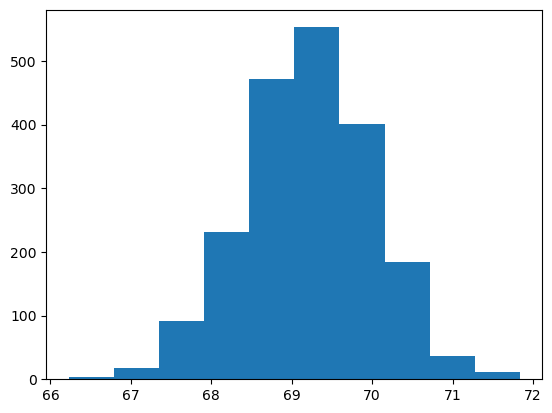

In [39]:
plt.hist(EMPulsar.GQ.q_samples[:,0].flatten())

In [312]:
EMPulsar.GMT.f[0]

Array([0.136344], dtype=float32)

In [185]:
def testfunc(m , mt, f ,mu_t, sigma_t):    
    return m**(4/3) / (3 * (mt - m)**2 * f**(1/3) * jnp.sqrt(1 - f**(2/3) * mt**(4/3) / (mt - m)**2)) * jax.scipy.stats.norm.pdf(mt, loc=mu_t, scale=sigma_t)

In [204]:
EMPulsar.GMT.f[1]**(2/3) * 1.665**(4/3) / (1.665 - 1.4)**2

Array([0.43515933], dtype=float32)

In [146]:
# Create the grid
mts = np.linspace(0, 6, 100)
mps = np.linspace(1, 3, 100)
X, Y = np.meshgrid(mts, mps)
Z = testfunc(X, Y, EMPulsar.GMT.f[1], EMPulsar.GMT.mu_mt[1], EMPulsar.GMT.sigma_mt[1]) * (mts > mps)

plt.contour(X, Y, Z, cmap='viridis')
plt.show()

NameError: name 'testfunc' is not defined

In [41]:
EMPulsar.GQ.q_samples.shape

(2000, 5, 1)

In [207]:
dat['mp']['name'][()]

array([b'4U1700-377', b'Cyg X-2', b'SMC X-1', b'Cen X-3',
       b'XTE J2123-058', b'4U 1822-371', b'OAO 1657-415',
       b'J013236.7+303228', b'Vela X-1', b'4U1538-522', b'LMC X-4',
       b'Her X-1', b'2S 0921-630', b'EXO 1722-363', b'SAX J1802.7-2017',
       b'XTE J1855-026', b'J0453+1559', b'J0453+1559 comp.',
       b'J1906+0746', b'J1906+0746 comp.', b'B1534+12', b'B1534+12 comp.',
       b'B1913+16', b'B1913+16 comp.', b'B2127+11C', b'B2127+11C comp.',
       b'J0737-3039A', b'J0737-3039B', b'J1756-2251', b'J1756-2251 comp.',
       b'J1807-2500B', b'J1807-2500B comp.', b'J2045+3633', b'J2053+4650',
       b'J1713+0747', b'B1855+09', b'J0751+1807', b'J1141-6545',
       b'J1738+0333', b'J1614-2230', b'J0348+0432', b'J2222-0137',
       b'J2234+0611', b'J1949+3106', b'J1012+5307', b'J0437-4715',
       b'J1909-3744', b'J1802-2124', b'J1911-5958A', b'J2043+1711',
       b'J0337+1715', b'J1946+3417', b'J1918-0642', b'J1600-3053',
       b'J0045-7319', b'J1023+0038', b'J1903+0327'

Text(0.5, 0, '$m_p$')

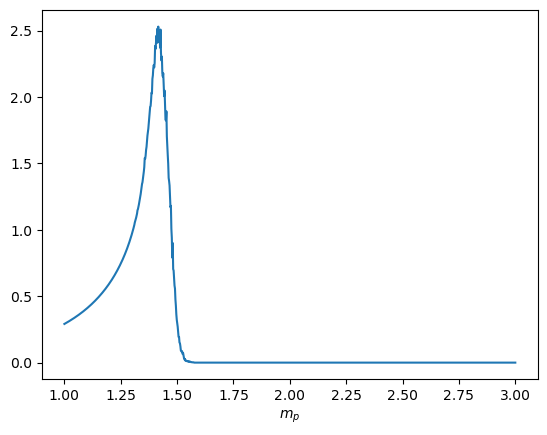

In [203]:
plt.plot(jnp.linspace(1,3,1000), Likes[10])
plt.xlabel("$m_p$")

Text(0.5, 0, '$m_p$')

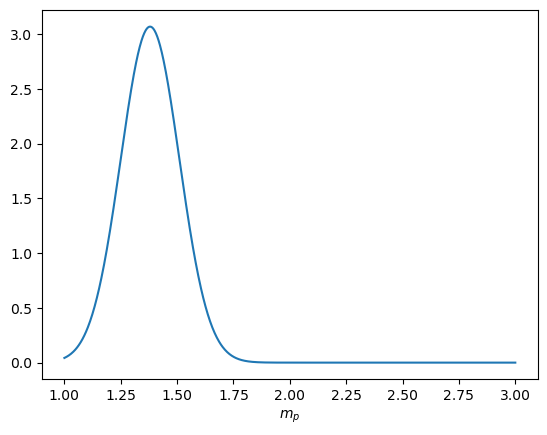

In [285]:
plt.plot(jnp.linspace(1,3,1001), Likes[66])
plt.xlabel("$m_p$")

In [218]:
len(dat['mt']['name'][()])

12

In [215]:
dat['q']['name'][()]

array([b'B1957+20', b'J1311-3430', b'J1740-5350', b'J1816+4510',
       b'J1723-2837'], dtype='|S10')

Text(0.5, 0, '$m_p$')

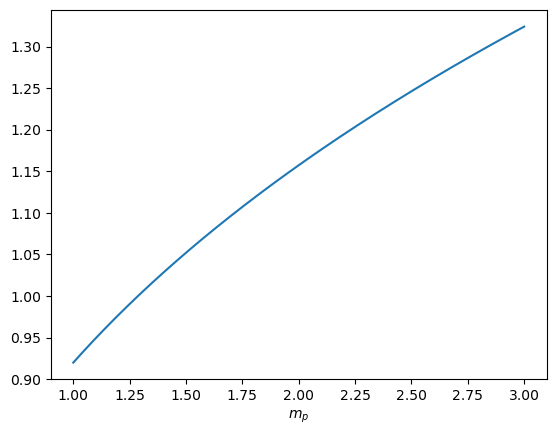

In [233]:
plt.plot(jnp.linspace(1,3,1000), Likes[14])
plt.xlabel("$m_p$")

Text(0.5, 0, '$m_p$')

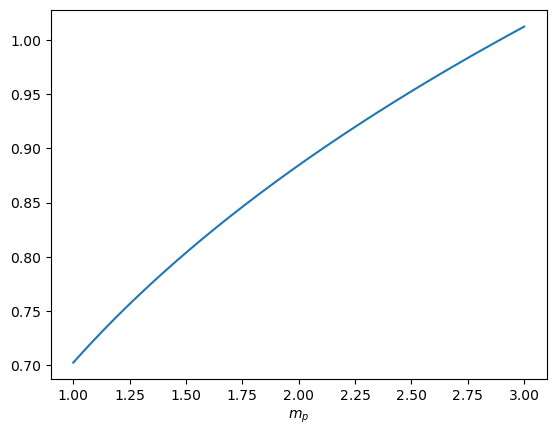

In [287]:
plt.plot(jnp.linspace(1,3,1001), Likes[15])
plt.xlabel("$m_p$")

In [116]:
def testfunc(m, mt, f):
    return f**(2/3) * mt**(4/3) / (mt - m)**2

In [119]:
masses=jnp.linspace(1,3,1000)
jnp.where(testfunc(masses, EMPulsar.GMT.mt_samples[:,1],  EMPulsar.GMT.f[1])>1)

(Array([   0,    0,    0, ..., 9999, 9999, 9999], dtype=int32),
 Array([248, 249, 250, ..., 415, 416, 417], dtype=int32))

In [102]:
EMPulsar.GMT.mt_samples[:,1]

Array([[1.6732486],
       [1.6674626],
       [1.6578697],
       ...,
       [1.6570717],
       [1.6783266],
       [1.659897 ]], dtype=float32)

In [101]:
testfunc(masses, EMPulsar.GMT.mt_samples[:,1],  EMPulsar.GMT.f[1])

Array([[6.1210794, 6.1754303, 6.230356 , ..., 6.671206 , 6.6568027,
        6.642462 ],
       [6.2305503, 6.28623  , 6.3425026, ..., 6.612439 , 6.5982533,
        6.5841265],
       [6.4186707, 6.4766545, 6.535265 , ..., 6.516715 , 6.5028796,
        6.489102 ],
       ...,
       [6.434705 , 6.4928865, 6.5516977, ..., 6.5088468, 6.4950395,
        6.4812913],
       [6.0273795, 6.080603 , 6.1343837, ..., 6.723434 , 6.708837 ,
        6.6943026],
       [6.3782067, 6.435692 , 6.493798 , ..., 6.536769 , 6.5228605,
        6.5090103]], dtype=float32)

In [8]:
GG = GGpulsar(jnp.array([1,2,3]),jnp.array([0.1, 0.3, 0.5]))

In [13]:
QG = QGpulsar(jnp.array([1,2,3]),jnp.array([0.1, 0.3, 0.5]), jnp.array([1,2,3]))

In [15]:
QG.likelihood_m(jnp.ones(8))

Array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32)